In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from scipy import optimize

In [54]:
## NEURON PARAMETERS
tau = 10.
eta_0 = 0.1
tau_adapt = 10.
rho_0 = 0.01
v = 0
delta_u = 1.
mu_M = 0.00001
tau_G = 10.
tau_baseline = 100.
dt = 1.

In [55]:
## NETWORK PARAMETERS

num_neurons = 9
num_timebins = 1000

## GENERATE WEIGHTS
weights = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights, 0)

## INITIALIZE DATA
phi = np.zeros(shape = (num_neurons, num_timebins))
rho = np.zeros(shape = (num_neurons, num_timebins))
eta = np.zeros(shape = (num_neurons, num_timebins))
u = np.zeros(shape = (num_neurons, num_timebins))
spikes = np.zeros(shape = (num_neurons, num_timebins))
spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta[:, 0] = np.zeros(num_neurons)
u[:, 0] = np.matmul(weights, phi[:, 0]) - eta[:, 0]
rho[:, 0] = rho_0 * np.exp(u[:, 0])
spike_probs[:, 0] = 1-np.exp(-rho[:, 0])
spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])



In [56]:
# RANDOM SPIKES

for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

In [98]:
## STAIRCASE PATTERN
neuron_block_size = np.floor(num_neurons / 3)
curr_neuron_block = 0
interval_idx = 0
timebin_counter = 0

gaussian_intervals = np.random.normal(size = 1000, loc=30, scale=10).astype(int)

spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1
    
for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential
    
    u[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 3.0
    nonblock_idx = np.delete(np.arange(num_neurons), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
    u[nonblock_idx, tt] -= 4.0

#     rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)
    rho[:, tt] = 1 / (1 + np.exp(-u[:, tt])) # np.exp((u[:, tt] - v) / delta_u)


#     rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 4.0
#     nonblock_idx = np.delete(np.arange(num_neurons), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
#     rho[nonblock_idx, tt] = 0.05 #rho_0 #np.maximum(rho[nonblock_idx, tt] - .1, 0)


#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = rho[:, tt] #1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])
    
    
    
        
    timebin_counter += 1
    if timebin_counter == gaussian_intervals[interval_idx]:
        interval_idx += 1
        timebin_counter = 0
        if curr_neuron_block < 2:
            curr_neuron_block += 1
        else:
            curr_neuron_block = 0

In [99]:
1 / (1 + np.exp(-10))

0.9999546021312976

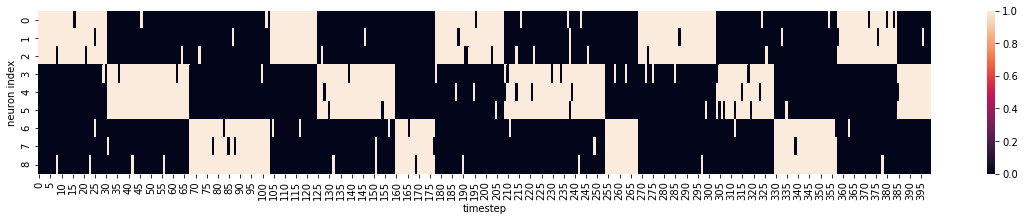

In [100]:
## HEATMAP DATA
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes[:, :400])
plt.xlabel("timestep")
plt.ylabel("neuron index")
plt.show()

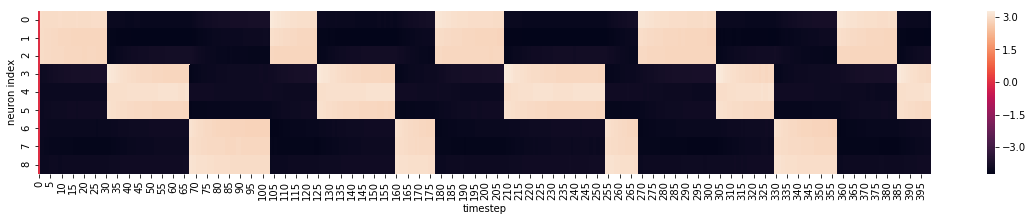

In [101]:
## HEATMAP DATA
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(u[:, :400])
plt.xlabel("timestep")
plt.ylabel("neuron index")
plt.show()

In [109]:
## LOG LIKELIHOOD FUNCTION
def log_likelihood(curr_weights):

#     total_potential = np.matmul(curr_weights, phi) - eta_0 * eta[0, :]

#     rho[0, :] = rho_0 * np.exp((total_potential - v) / delta_u)
#     LL = np.sum(np.multiply(np.log(rho[0, :]), spikes[0, :]) - rho[0, :]) * dt

    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    rho = rho_0 * np.exp((total_potential - v) / delta_u)
    LL = np.sum(np.multiply(spikes, np.log(rho)) * dt + np.multiply((1 - spikes), np.log(1 - rho * dt)))

    return -LL

In [110]:
np.sum(np.multiply(spikes, np.log(rho)) * dt + np.multiply((1 - spikes), np.log(1 - rho * dt)))

-1250.6384045848354

In [111]:
## USE SCIPY OPTIMIZE TO LEARN WEIGHTS
x0 = np.random.normal(loc=0, scale=0.1, size=num_neurons*num_neurons)
res = optimize.minimize(log_likelihood, x0, options={'disp': True}, tol=1e-5) #, method = "BFGS")
scipy_learned_weights = np.reshape(res.x, [num_neurons, num_neurons])

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


         Current function value: nan
         Iterations: 1
         Function evaluations: 9296
         Gradient evaluations: 112


In [18]:
print "LL: {}, MSE: {}".format(log_likelihood(scipy_learned_weights), np.sum((scipy_learned_weights - weights)**2))

LL: nan, MSE: 1069694.73694


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


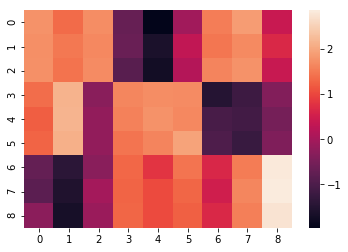

In [445]:
sns.heatmap(np.reshape(scipy_learned_weights, [num_neurons, num_neurons]))

In [447]:
# ## LEARN WEIGHTS VIA GRADIENT DESCENT
# from autograd import grad
# import autograd.numpy as np

# x0 = np.random.normal(loc=0, scale=0.1, size=[num_neurons, num_neurons])
# learned_weights_GD = x0

# # AUTOGRAD GRADIENT
# grad_LL = grad(log_likelihood)

# LL_trace = []
# for inum in range(40000):
#     curr_LL = log_likelihood(learned_weights_GD)
#     LL_trace.append(curr_LL)
#     M_weights_gradients = grad_LL(learned_weights_GD)

#     learned_weights_GD -= 0.001 * M_weights_gradients
#     if inum % 3000 == 0:
#         print curr_LL
#         print np.sum((learned_weights_GD - weights)**2)

In [448]:
# sns.heatmap(np.reshape(learned_weights_GD, [num_neurons, num_neurons]))

In [449]:
# plt.plot(LL_trace)
# plt.show()

In [450]:
# print "LL: {}, MSE: {}".format(log_likelihood(learned_weights_GD), np.sum((learned_weights_GD - weights)**2))

In [459]:
## SIMULATE NETWORK WITH LEARNED WEIGHTS

weights_to_use = scipy_learned_weights
# weights_to_use = learned_weights_GD
curr_neuron_block = 0
spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1
# phi[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 4
# eta[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 4
# u[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 10


for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights_to_use, phi[:, tt]) - eta_0 * eta[:, tt]
    
    u[:, tt] = total_potential 

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

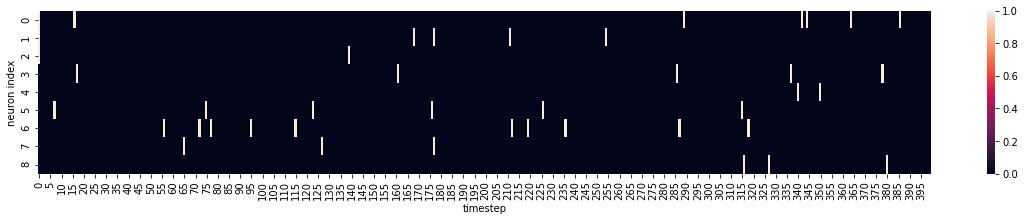

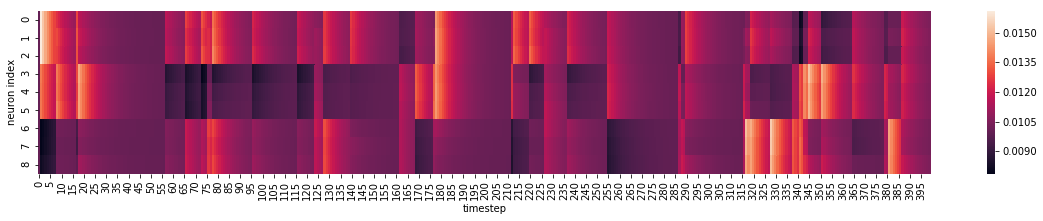

In [460]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes[:, :400])
plt.xlabel("timestep")
plt.ylabel("neuron index")
plt.show()

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(rho[:, :400])
plt.xlabel("timestep")
plt.ylabel("neuron index")
plt.show()